# Importing Modules

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

# Importing Dataset

In [ ]:
df = pd.read_csv('data.csv')
df.drop(columns=['No'],inplace=True)
df.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


# Dropping Missing Value Rows

In [ ]:
df.dropna(inplace=True)

# Encoding Categorical Columns

In [ ]:
cols = ['year','cbwd']
label_encoder = LabelEncoder() 
df[cols] = df[cols].apply(label_encoder.fit_transform)

In [ ]:
y = df['month']
X = df.drop(columns=['month'])

# Splitting Dataset Into Train, Validation and Test Sets

In [ ]:
def train_val_test_split(data,random_state,val_size=0.15,test_size=0.15):
  """
  Train Valdiation Test split implemented from scratch. Takes the dataset,
  val_size, test_size and random_state as parameters and returns the train,
  validation and test sets.

  Calculates the length of train, test and validation sets, shuffles the 
  dataset and returns the 3 sets.
  """
  
  shuffled_data = data.sample(frac=1,random_state=random_state)

  val_size = int(len(data)*val_size)
  test_size = int(len(data)*test_size)
  train_size = len(data)-val_size-test_size

  train = shuffled_data[:train_size]
  val = shuffled_data[train_size:train_size+val_size]
  test = shuffled_data[train_size+val_size:]

  return train,val,test

In [ ]:
df_train, df_val, df_test = train_val_test_split(df,random_state=42)

# Splitting Into X and y values

In [ ]:
y_train = df_train['month']
X_train = df_train.drop(columns=['month'])

y_val = df_val['month']
X_val = df_val.drop(columns=['month'])

y_test = df_test['month']
X_test = df_test.drop(columns=['month'])

In [ ]:
def accuracy(y_true,y_pred):
  y_true = y_true.to_numpy()
  return np.sum(y_true==y_pred)/len(y_true)

# A. Training Decision Tree Model

In [ ]:
def train_predict_evaluate(model):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  print("Accuracy: ",accuracy(y_test,y_pred))

In [ ]:
train_predict_evaluate(DecisionTreeClassifier(criterion='gini',random_state=0))

Accuracy:  0.8227686412262494


In [ ]:
train_predict_evaluate(DecisionTreeClassifier(criterion='entropy',random_state=0))

Accuracy:  0.8305923678748204


# B. Training Decision Tree Model on Different Max Depths

In [ ]:
depths = [2,4,8,10,15,30]
train_accuracy = []
test_accuracy = []

for depth in depths:
  decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=depth,random_state=0)
  decision_tree.fit(X_train,y_train)
  y_pred_train = decision_tree.predict(X_train)
  y_pred_test = decision_tree.predict(X_test)
  train_accuracy.append(accuracy(y_train,y_pred_train))
  test_accuracy.append(accuracy(y_test,y_pred_test))

In [ ]:
print("Train Accuracy: ",train_accuracy)
print("Test Accuracy: ",test_accuracy)

Train Accuracy:  [0.27528993192159007, 0.39885737744175703, 0.5873558892956108, 0.7071602066299476, 0.9573398104751805, 1.0]
Test Accuracy:  [0.2818138272393422, 0.40268242056522435, 0.5700143701101709, 0.6501676512853265, 0.8064825163659588, 0.8305923678748204]


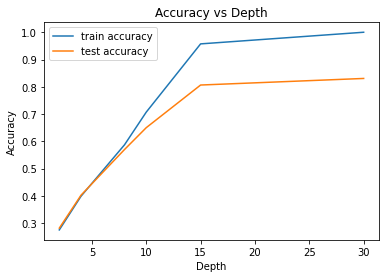

In [ ]:
plt.plot(depths,train_accuracy,label='train accuracy')
plt.plot(depths,test_accuracy,label='test accuracy')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Depth")
plt.legend()
plt.show()

# C.

In [ ]:
def random_selection(data,size=0.5):
  """
  Trains the training data and returns a random 50%.
  """

  shuffled_data = data.sample(frac=0.5)
  return shuffled_data

In [ ]:
def ensemble(n_estimators=100,max_depth=3):
  """
  Combines 100 decision tree stumps trained on random 50% of the training data, predicts the
  testing samples by taking mode over the predictions.
  """
  predictions = []

  for i in range(n_estimators):
    data = random_selection(df_train)
    y = data['month']
    X = data.drop(columns=['month'])
    decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=max_depth,random_state=0)
    decision_tree.fit(X,y)
    predictions.append(decision_tree.predict(X_test))

  y_pred = pd.DataFrame(predictions).T.mode(axis='columns')[0]
  y_test_ = y_test.reset_index(drop=True)

  print("Accuracy: ",accuracy(y_test_,y_pred))

In [ ]:
ensemble()

Accuracy:  0.3557400606737985


# D.

In [ ]:
def tuning(n_estimators=100):
  """
  Function for tuning decision stump by changing max depth and n estimators.
  Train, Validation and Test Accuracies are returned for different values
  of max_depth and n_estimators
  """
  depths = [4,8,10,15,20,30]
  results = []
  y_test_ = y_test.reset_index(drop=True)

  #trains decision tree stumps on different depths, stores the train, test and
  # validation predictions

  for depth in depths:
    predictions_train = []
    predictions_val = []
    predictions_test = []
    for i in range(n_estimators):
      data = random_selection(df_train)
      y = data['month']
      X = data.drop(columns=['month'])
      decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=depth,random_state=0)
      decision_tree.fit(X,y)
      predictions_train.append(decision_tree.predict(X_train))
      predictions_val.append(decision_tree.predict(X_val))
      predictions_test.append(decision_tree.predict(X_test))

    # takes mode over predictions to find y_pred
    num = [4,8,10,15,20,100]
    for n in num:
      y_pred_train = pd.DataFrame(predictions_train[:n]).T.mode(axis='columns')[0]
      y_pred_val = pd.DataFrame(predictions_val[:n]).T.mode(axis='columns')[0]
      y_pred_test = pd.DataFrame(predictions_test[:n]).T.mode(axis='columns')[0]
      accuracy_train = accuracy(y_train,y_pred_train)
      accuracy_val = accuracy(y_val,y_pred_val)
      accuracy_test = accuracy(y_test,y_pred_test)
      result = {'depth':depth,
                      'n_estimator':n,
                      'train accuracy':accuracy_train,
                      'validation accuracy': accuracy_val,
                      'test accuracy': accuracy_test}
      print(result)
      results.append(result)

  return results

In [ ]:
def save_and_load_results():
  if not os.path.exists("D_results.csv"):
    results = tuning()
    res = pd.DataFrame.from_dict(results)
    res.to_csv('D_results.csv')
  return pd.read_csv('D_results.csv',index_col=0)
  

In [ ]:
D_results = save_and_load_results()

{'depth': 4, 'n_estimator': 4, 'train accuracy': 0.39892579795422667, 'validation accuracy': 0.38591729203257225, 'test accuracy': 0.4041194315823088}
{'depth': 4, 'n_estimator': 8, 'train accuracy': 0.4071704697068181, 'validation accuracy': 0.4036404279099473, 'test accuracy': 0.4100271435414338}
{'depth': 4, 'n_estimator': 10, 'train accuracy': 0.4165098696589237, 'validation accuracy': 0.4089094683059237, 'test accuracy': 0.4208845601149609}
{'depth': 4, 'n_estimator': 15, 'train accuracy': 0.4169203927337416, 'validation accuracy': 0.4097078077598595, 'test accuracy': 0.41928788120708926}
{'depth': 4, 'n_estimator': 20, 'train accuracy': 0.4153467209469399, 'validation accuracy': 0.4049177710362446, 'test accuracy': 0.4221619032412582}
{'depth': 4, 'n_estimator': 100, 'train accuracy': 0.412678320960624, 'validation accuracy': 0.4015647453297142, 'test accuracy': 0.41912821331630207}
{'depth': 8, 'n_estimator': 4, 'train accuracy': 0.6270397865280011, 'validation accuracy': 0.5958

In [ ]:
print(display(D_results))

,depth,n_estimator,train accuracy,validation accuracy,test accuracy
0,4,4,0.398926,0.385917,0.404119
1,4,8,0.407170,0.403640,0.410027
2,4,10,0.416510,0.408909,0.420885
3,4,15,0.416920,0.409708,0.419288
4,4,20,0.415347,0.404918,0.422162
5,4,100,0.412678,0.401565,0.419128
6,8,4,0.627040,0.595881,0.605301
7,8,8,0.634806,0.605301,0.609772
8,8,10,0.640450,0.612646,0.620789
9,8,15,0.647669,0.622385,0.624142


None


# E.

#### Adaboost with Decision Tree as base estimator and different n_estimators

In [ ]:
number_of_estimators = [4,8,10,15,20]

for num in number_of_estimators:
  ada_boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',random_state=0),n_estimators=num)
  ada_boost.fit(X_train,y_train)
  y_pred = ada_boost.predict(X_test)
  print("Accuracy Score for n_estimators = "+str(num)+": "+str(accuracy(y_test,y_pred)))

Accuracy Score for n_estimators = 4: 0.8286763531853745
Accuracy Score for n_estimators = 8: 0.8323487146734792
Accuracy Score for n_estimators = 10: 0.8336260577997765
Accuracy Score for n_estimators = 15: 0.8315503752195433
Accuracy Score for n_estimators = 20: 0.8318697110011177
